<a href="https://colab.research.google.com/github/rodgerrashan/fed-reasoning-cyber/blob/main/detectionModel/AE_training_FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Zero Day Attack detection

Library installation

In [23]:
!pip install -q tensorflow scikit-learn pandas numpy matplotlib seaborn

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.ensemble import IsolationForest

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping


Mounting G Drive

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load CIC-IDS 2017 CSV Files

In [26]:
benign_filepath = "/content/drive/MyDrive/FYP/Data/UNSW NB15/UNSW_NB15_training-set.csv"

df = pd.read_csv(benign_filepath)
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [27]:
df.shape

(175341, 45)

In [14]:
# df.info()

#### PreProcessing

In [28]:
def clean_data(df):
  df = df.replace([np.inf, -np.inf], np.nan)
  df = df.dropna()
  return df

cleaned_df = clean_data(df)

# Strip white spapces in column names
cleaned_df.columns = cleaned_df.columns.str.strip()

cleaned_df.shape

(175341, 45)

Here label processign happens:

* BENIGN -> 0
* Attack -> 1

In [34]:
# cleaned_df.info()

In [33]:
# Drop unnecessary columns
df = cleaned_df.drop(['id', 'attack_cat'], axis=1)

# seperate labels
y = df['label']
X = df.drop(columns = ['label'])

According to the d.info, we have here several categorical column features such as 'proto', 'service', 'state'. So we have to perform one-hot encoding.

In [35]:
categorical_cols = ['proto', 'service', 'state']
numeric_cols = X.columns.difference(categorical_cols)

In [36]:
X_cat = pd.get_dummies(X[categorical_cols], drop_first=True)   # avoid redundancy
X_num = X[numeric_cols]

In [37]:
X_processed = pd.concat([X_num, X_cat], axis=1)
X_processed.shape

(175341, 191)

We proposed to use Autoencoders for here. So AE should be trained only on normal traffic.

In [38]:
X_train = X_processed[y == 0]

X_test = X_processed # all data to test
y_test = y

Next, we have to do feature scaling.

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


#### Build AutoEncoder Model

In [69]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

input_dim = X_train_scaled.shape[1]

input_layer = Input(shape=(input_dim,))

encoded = Dense(128, activation='relu')(input_layer)
encoded = Dropout(0.3)(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dropout(0.3)(decoded)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 191)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 191)            │        24,639 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,983 (273.37 KB)

 Trainable params: 69,983 (273.37 KB)

 Non-trainable params: 0 (0.00 B)

#### Model Training

In [71]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

history = autoencoder.fit(
    X_train_scaled,
    X_train_scaled,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0448 - val_loss: 0.1163
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0577 - val_loss: 0.1183
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0534 - val_loss: 0.1147
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0482 - val_loss: 0.1160
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0634 - val_loss: 0.1204
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0427 - val_loss: 0.1137
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0526 - val_loss: 0.1158
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0496 - val_loss: 0.1158
Epoch 9/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0668 - val_loss: 0.1157
Epoch 10/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0626 - val_loss: 0.1135
Epoch 11/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0322 - val_loss: 0.1171
Epoch 12/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms

#### Detection logic and testing

In [72]:
# Calculate reconstruction error
reconstructions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.square(X_test_scaled - reconstructions), axis=1)

5480/5480 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


In [73]:
from sklearn.metrics import f1_score

thresholds = np.percentile(mse, np.arange(80, 99))
f1_scores = []

for t in thresholds:
    preds = (mse > t).astype(int)
    f1_scores.append(f1_score(y_test, preds))

best_t = thresholds[np.argmax(f1_scores)]
print("Best threshold:", best_t)


Best threshold: 0.16789828938974444


In [74]:
# Threshold section
# threshold = np.percentile(mse, 60)
y_pred = (mse > best_t).astype(int)

              precision    recall  f1-score   support

           0       0.40      0.99      0.57     56000
           1       0.99      0.29      0.45    119341

    accuracy                           0.52    175341
   macro avg       0.69      0.64      0.51    175341
weighted avg       0.80      0.52      0.49    175341

ROC-AUC: 0.8833675598106028


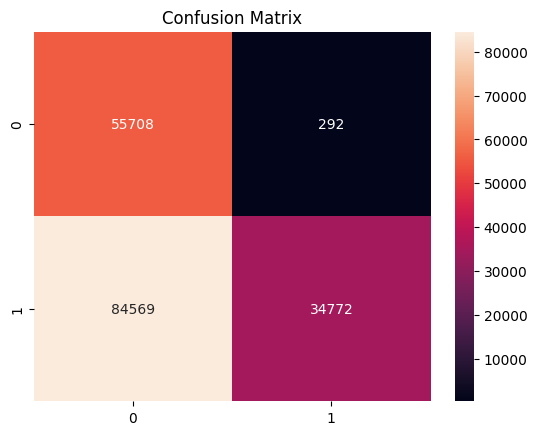

In [75]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, mse))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()
